In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import scipy
from scipy.signal import spectrogram
from collections import Counter
from scipy.ndimage import gaussian_filter
import h5py

In [3]:
import ei
import full_band

In [4]:
# input data
def input_data(mat_filename):
    mat_data = h5py.File(mat_filename)
    modified_mat_data = np.transpose(mat_data['mat_data'])
    fs = mat_data['fs'][0][0]
    ch_labels = mat_data['channel_labels']
    chans_list = []
    for i in range(ch_labels.shape[0]):
        tmp_ch_name = ''.join([chr(v[0]) for v in mat_data[(ch_labels[i][0])]])
        chans_list.append(tmp_ch_name)
    data = {'modified_mat_data': modified_mat_data, 'fs': fs, 'chans_list': chans_list}
    print('data loaded')
    return data

mat_filename = './data/S1.mat'
data = input_data(mat_filename)

data loaded


In [5]:
# filter data function
def filter_data(modified_mat_data, fs, band_low, band_high):
    nyq = fs / 2
    b, a = scipy.signal.butter(5, np.array([band_low / nyq, band_high / nyq]), btype='bandpass')
    new_modified_mat_data = scipy.signal.filtfilt(b, a, modified_mat_data)
    return new_modified_mat_data


# set default target and baseline
def cut_data(modified_mat_data):
    target_data = modified_mat_data
    baseline_data = modified_mat_data[:, :int(modified_mat_data.shape[1]/5)]
    return target_data, baseline_data

In [6]:
# refresh electrodes' name and number
def refresh_electrodes_info(chans_list):
    tmp_chs_names = chans_list
    tmp_chlabel_list = [x[0] if x[1].isdigit() else x[:2] for x in tmp_chs_names]
    chs_counter = Counter(tmp_chlabel_list)
    chs_info = chs_counter.items()
    single_chns = [x for x in chs_info if len(x[0]) == 1]
    double_chns = [x for x in chs_info if len(x[0]) == 2]
    single_chns.sort(key=lambda x: x[0])
    double_chns.sort(key=lambda x: x[0])
    if double_chns != []:
        elecs_info = np.concatenate([np.array(single_chns), np.array(double_chns)], axis=0)
    else:
        elecs_info = np.array(single_chns)
    return elecs_info, chs_info

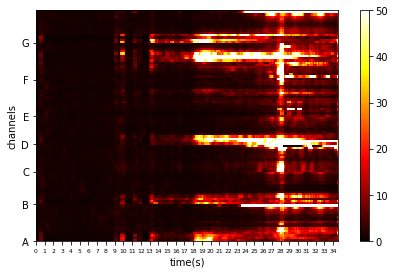

In [7]:
# hfer plot function
def hfer_plot_func(data):
    modified_mat_data = data['modified_mat_data']
    fs = data['fs']
    chans_list = data['chans_list']
    # hfer computation
    filted_data = filter_data(modified_mat_data, fs, 60, 140)
    target_data, baseline_data = cut_data(filted_data)
    norm_target, norm_base = ei.compute_hfer(target_data, baseline_data, fs)
    # plot hfer
    elecs_info, chs_info = refresh_electrodes_info(chans_list)
    elec_labels = [x[0] for x in elecs_info]
    elec_nums = [int(x[1]) for x in elecs_info]
    hfer_fig = plt.figure('hfer')
    hfer_ax = hfer_fig.add_axes([0.1, 0.1, 0.7, 0.8])
    tmp_x, tmp_y = np.meshgrid(np.arange(norm_target.shape[1] + 1), np.arange(norm_target.shape[0] + 1))
    surf = hfer_ax.pcolormesh(tmp_x, tmp_y, norm_target, cmap=plt.cm.hot, vmax=50, vmin=0)
    hfer_ax.set_xticks(np.arange(0, norm_target.shape[1], 2000))
    hfer_ax.set_xticklabels(np.rint(np.arange(0, norm_target.shape[1],2000) / float(fs)).astype(np.int16), fontsize=6)
    hfer_ax.set_xlabel('time(s)')
    hfer_ax.set_ylabel('channels')
    color_cums = np.cumsum(elec_nums)
    tmp_color_cums = np.concatenate([np.array([0]), color_cums])
    y_ticks = [tmp_color_cums[i - 1] for i in range(1, len(tmp_color_cums))]
    hfer_ax.set_yticks(y_ticks)
    hfer_ax.set_yticklabels(elec_labels)
    color_bar_ax = hfer_fig.add_axes([0.85, 0.1, 0.02, 0.8])
    plt.colorbar(surf, cax=color_bar_ax, orientation='vertical')
    plt.show()

hfer_plot_func(data)

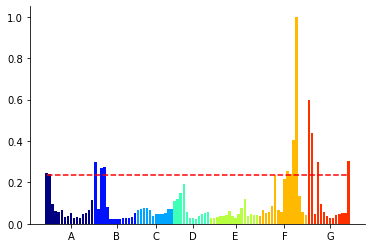

In [8]:
# ei plot
def ei_plot_func(data):
    modified_mat_data = data['modified_mat_data']
    fs = data['fs']
    chans_list = data['chans_list']
    # calculate ei
    filted_data = filter_data(modified_mat_data, fs, 60, 140)
    target_data, baseline_data = cut_data(filted_data)
    norm_target, norm_base = ei.compute_hfer(target_data, baseline_data, fs)
    ei_ei, ei_hfer, ei_onset_rank = ei.compute_ei_index(norm_target, norm_base, fs)
    ei_thresh = np.mean(ei_ei) + np.std(ei_ei)

    # plot ei
    ei_ei_fig = plt.figure('ei')
    ei_ei_ax = ei_ei_fig.add_subplot(111)
    elecs_info, chs_info = refresh_electrodes_info(chans_list)
    elec_labels = [x[0] for x in elecs_info]
    elec_nums = [int(x[1]) for x in elecs_info]
    color_rgb = cm.jet(np.arange(len(elec_nums)) / float(len(elec_nums)))
    color_cums = np.cumsum(elec_nums)
    ei_ei_ax.bar(range(color_cums[0]), ei_ei[:color_cums[0]], color=color_rgb[0])
    for j in range(1, len(elec_nums)):
        ei_ei_ax.bar(range(color_cums[j - 1], color_cums[j]), ei_ei[color_cums[j - 1]:color_cums[j]],
                     color=color_rgb[j])
    tmp_color_cums = np.concatenate([np.array([0]), color_cums])
    x_ticks = [(tmp_color_cums[i - 1] + tmp_color_cums[i]) / 2.0 for i in range(1, len(tmp_color_cums))]
    ei_ei_ax.set_xticks(x_ticks)
    ei_ei_ax.set_xticklabels(elec_labels)
    ei_ei_ax.plot(np.arange(len(ei_ei)), ei_thresh * np.ones(len(ei_ei)), 'r--')
    ei_ei_ax.spines['top'].set_visible(False)
    ei_ei_ax.spines['right'].set_visible(False)
    plt.show()

ei_plot_func(data)

computing spectrogram
0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
dimensionality reducing
clustering
electrodes: ['A1' 'A2' 'A3' 'A4' 'B1' 'B2' 'B3' 'D1' 'D2' 'D3' 'D4' 'F9' 'F10' 'F11'
 'F12' 'F13' 'G1' 'G2' 'G3' 'G4']


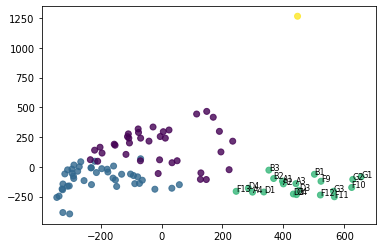

In [9]:
# full band plot
def full_band_plot_func(data):
    modified_mat_data = data['modified_mat_data']
    fs = data['fs']
    chans_list = data['chans_list']
    # ei computation
    filted_data = filter_data(modified_mat_data, fs, 60, 140)
    target_data, baseline_data = cut_data(filted_data)
    norm_target, norm_base = ei.compute_hfer(target_data, baseline_data, fs)
    ei_ei, ei_hfer, ei_onset_rank = ei.compute_ei_index(norm_target, norm_base, fs)
    spec_pca, fullband_labels, fullband_ind = full_band.compute_full_band(modified_mat_data, fs, ei_ei)
    chs_labels = np.array(chans_list)[fullband_ind]
    print('electrodes:', chs_labels)

    # plot full band result
    fullband_fig = plt.figure('full_band')
    fullband_ax = fullband_fig.add_subplot(111)
    fullband_ax.scatter(spec_pca[:, 0], spec_pca[:, 1], alpha=0.8, c=fullband_labels)
    for ind in fullband_ind:
        fullband_ax.text(spec_pca[ind, 0], spec_pca[ind, 1], chans_list[ind],fontsize=8, color='k')
    plt.show()
    
full_band_plot_func(data)